# Rag From Scratch: Query Transformations
Query transformations are a set of approaches focused on re-writing and / or modifying questions for retrieval.
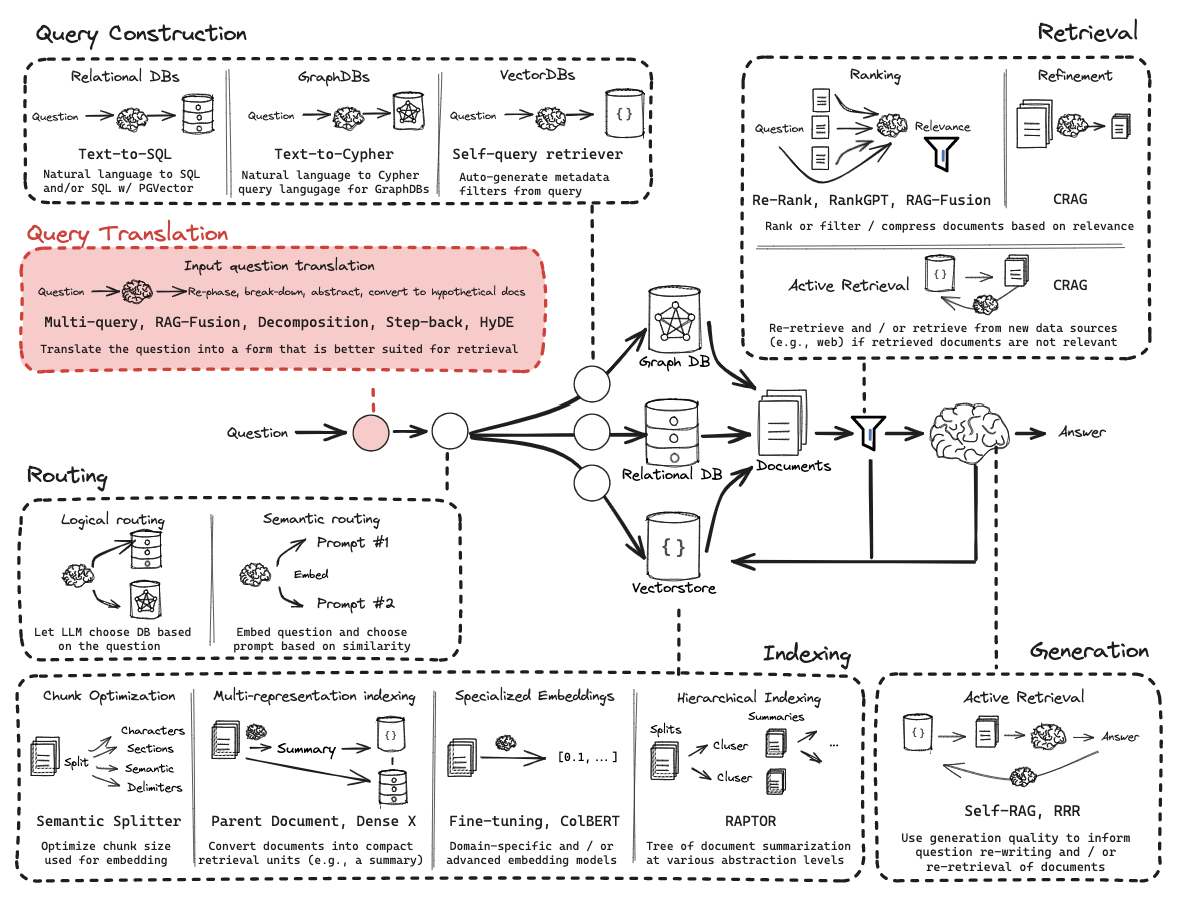


## Approach : Multi Query
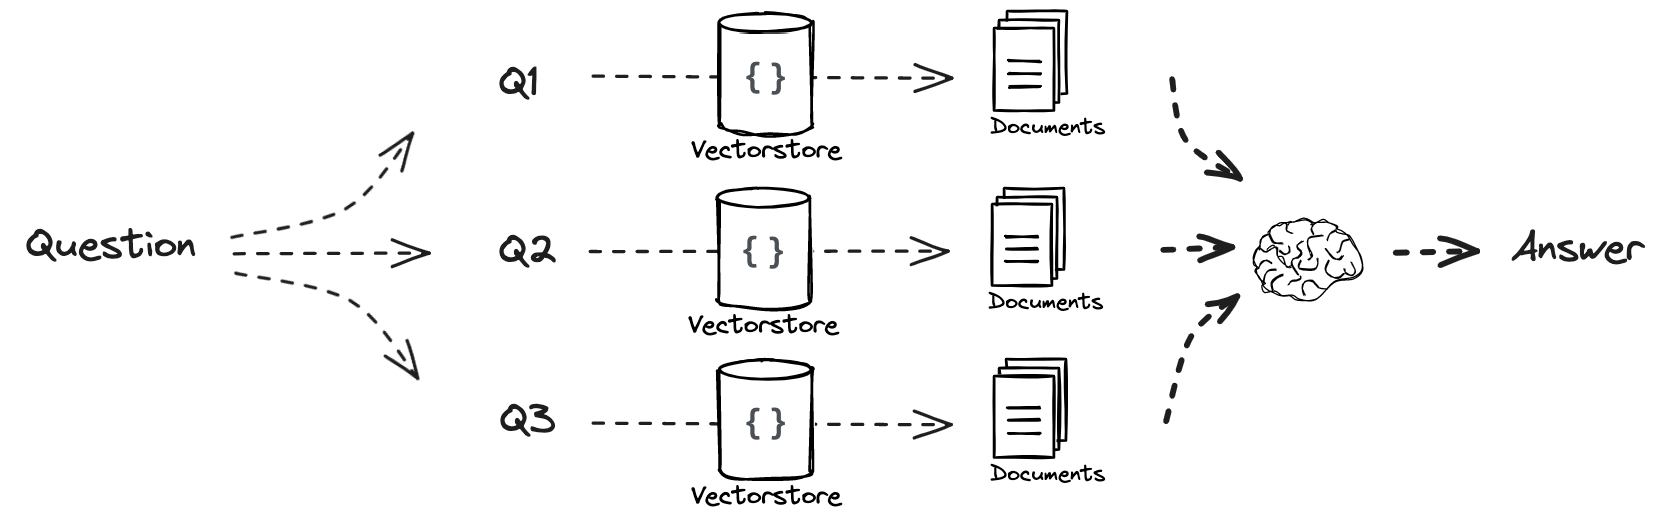

Docs:

https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever

In [2]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_community.vectorstores import Chroma


# Embed
from gen_ai_hub.proxy.langchain.init_models import  init_embedding_model
embeddings = init_embedding_model(model_name ='text-embedding-ada-002')
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=embeddings)

retriever = vectorstore.as_retriever()

In [4]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser

from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm(model_name="gpt-4o",temperature=0)

generate_queries = (
    prompt_perspectives 
    | llm 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [5]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

/var/folders/56/hr4t2kyn4zd1r_vn51tycxyh0000gn/T/ipykernel_39623/2784938305.py:10: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  return [loads(doc) for doc in unique_docs]


8

In [ ]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)


final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM (Large Language Model) agents involves breaking down large, complex tasks into smaller, manageable subgoals. This process enables the efficient handling of intricate tasks by simplifying them into more straightforward steps. There are several methods for task decomposition:\n\n1. **Chain of Thought (CoT)**: This technique instructs the model to "think step by step," allowing it to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and provides an interpretation of the model’s thinking process.\n\n2. **Tree of Thoughts (ToT)**: This method extends CoT by exploring multiple reasoning possibilities at each step. It decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be either breadth-first search (BFS) or depth-first search (DFS), with each state evaluated by a classifier (via 

## Approach: RAG-Fusion
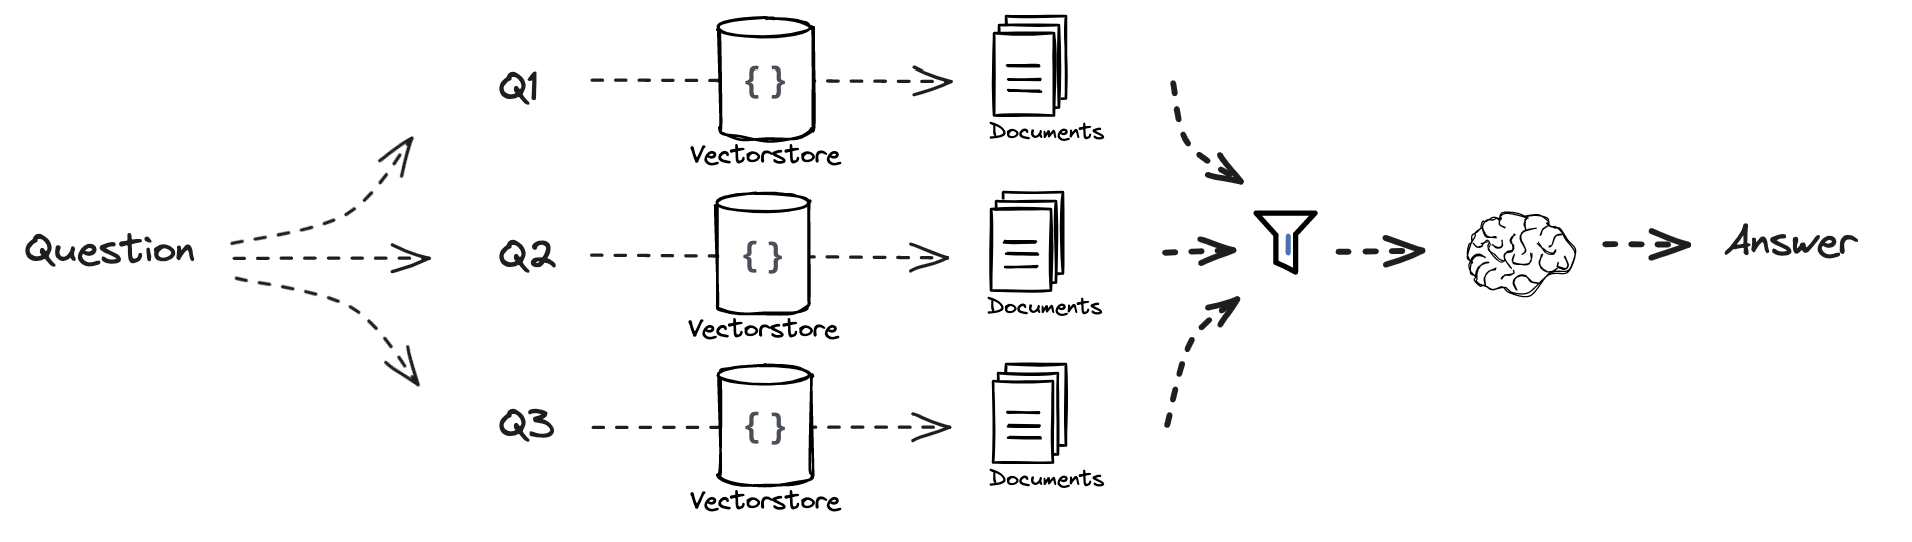

Docs:

https://github.com/langchain-ai/langchain/blob/master/cookbook/rag_fusion.ipynb?ref=blog.langchain.dev

Blog / repo:

https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1

In [9]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [10]:
from langchain_core.output_parsers import StrOutputParser


from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm(model_name="gpt-4o",temperature=0)
generate_queries = (
    prompt_rag_fusion 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [11]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

7

# Reciprocal Rank Fusion

## The formula in one sentence
The code
fused_scores[doc_str] += 1 / (rank + k)
implements Reciprocal Rank Fusion (RRF). For each time a document appears at position `rank` in one ranked list, it adds the value 1/(rank + k) to the document's running score. Lower ranks (better positions) contribute more; summing across lists favors documents that appear high in many lists.

## Why 1/(rank + k)?
- If rank = 0 and k = 60 → contribution = 1/60 ≈ 0.0167
- If rank = 1 and k = 60 → contribution = 1/61 ≈ 0.0164
So the top item has a slightly larger contribution; repeated top placements add up. Using 1/(rank + k) keeps contributions positive and smoothly decreasing with rank. k prevents the top item from completely dominating (if k were 0, top item would have contribution 1 and would dominate).

## Tiny worked examples

Example A — single list (just to see one contribution)
- k = 60
- List: [D1 (rank 0), D2 (rank 1)]
Contributions:
- D1: 1/(0+60) = 0.0166667
- D2: 1/(1+60) ≈ 0.0163934
Final ranking: D1 then D2 (D1 slightly higher).

Example B — two lists, some overlap
Lists (k = 60):
- List 1: [D1 (rank0), D2 (rank1), D3 (rank2)]
- List 2: [D2 (rank0), D3 (rank1), D4 (rank2)]

Compute contributions:
- D1: appears once at rank0 → 1/60 ≈ 0.016667
- D2: rank1 in list1 → 1/61 ≈ 0.016393 + rank0 in list2 → 1/60 = 0.016667 → total ≈ 0.03306
- D3: rank2 in list1 → 1/62 ≈ 0.016129 + rank1 in list2 → 1/61 ≈ 0.016393 → total ≈ 0.032522
- D4: rank2 in list2 → 1/62 ≈ 0.016129

Final fused scores (descending):
- D2 ≈ 0.03306 (best: appears at rank 0 once + rank 1 once)
- D3 ≈ 0.03252
- D1 ≈ 0.016667
- D4 ≈ 0.016129

Notice: D2 wins because it appears high across lists even though it isn’t top in both lists.

Example C — effect of k (same lists as B)
- If k = 1 (small), contributions become:
  - weight(rank0)=1/1 = 1.0, weight(rank1)=1/2=0.5, weight(rank2)=1/3≈0.333
  - D2: 0.5 + 1.0 = 1.5
  - D3: 0.333 + 0.5 = 0.833
  - D1: 1.0
  - D4: 0.333
  - Ranking more strongly favors top positions (D2 far ahead).
- If k = 100 (large), contributions are nearly equal across top ranks (differences shrink), so documents that appear in many lists (even moderately ranked) catch up.

Summary: smaller k → more emphasis on top positions; larger k → smoother, more robust to rank noise.

## Visual intuition
Imagine each appearance gives the doc a small “vote weight” that decreases as rank increases. You add all votes from all lists. Documents that consistently get many votes (especially near the top) accumulate the highest total.

## Practical tips
- Use a stable document key (id) instead of serializing entire documents to strings to avoid duplication issues.
- Typical default k used in literature/implementations: 60. It’s empirical — try 30, 60, 100 to see effect.
- If you want just top results, compute scores then return top-K.
- If lists have meaningful numeric scores (not only ranks), consider score-combining methods (CombSUM) instead — RRF is best when you have only rankings or scores that aren’t comparable across retrievers.

## Quick pseudo-calculation (recap)
For two lists, k=60:
- doc A ranks: 0 in list1, not present in list2 → score = 1/60 = 0.016667
- doc B ranks: 1 in list1, 0 in list2 → score = 1/61 + 1/60 ≈ 0.03306

B > A because B appears higher overall across lists.

If you want, I can:
- Add a small notebook cell that computes fused scores for a toy example and prints step-by-step contributions (so you can see the numbers). Would you like that?

In [15]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM (Large Language Model) agents involves breaking down large, complex tasks into smaller, more manageable subgoals. This process enables the agent to handle complex tasks more efficiently. There are several methods for task decomposition:\n\n1. **Chain of Thought (CoT)**: This technique instructs the model to "think step by step," decomposing hard tasks into smaller, simpler steps. It transforms big tasks into multiple manageable tasks and provides insight into the model’s thinking process.\n\n2. **Tree of Thoughts (ToT)**: This method extends CoT by exploring multiple reasoning possibilities at each step. It decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be breadth-first search (BFS) or depth-first search (DFS), with each state evaluated by a classifier or majority vote.\n\n3. **Simple Prompting**: Task decomposition can be done by prompting the LLM with instructio

# Approach: Decomposition

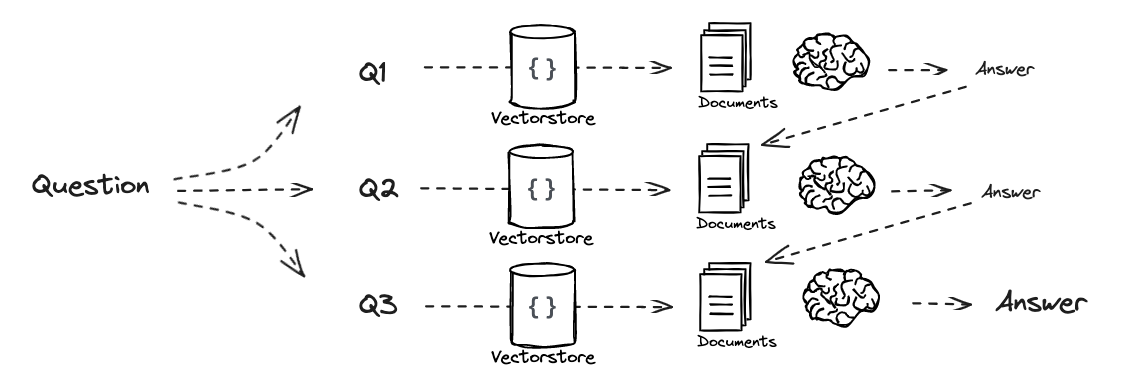

**Aggregate answers**

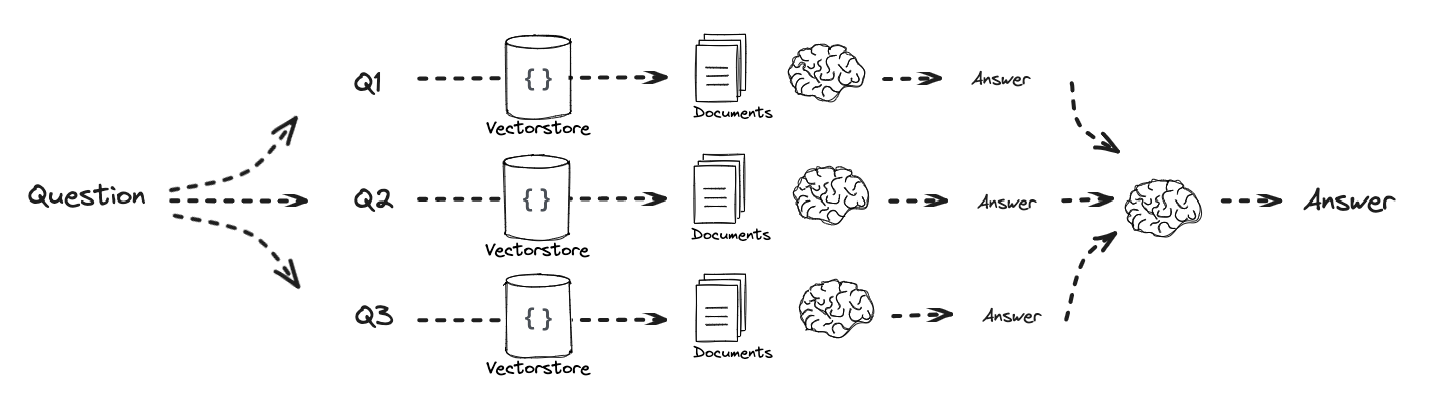

Papers:

- https://arxiv.org/pdf/2205.10625.pdf
- https://arxiv.org/abs/2212.10509.pdf

In [23]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [24]:
from langchain_core.output_parsers import StrOutputParser

# LLM
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm(model_name="gpt-4o",temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})
questions

['1. What are the key hardware components required for an LLM-powered autonomous agent system?',
 '2. What software frameworks and libraries are essential for developing an LLM-powered autonomous agent system?',
 '3. How do LLMs integrate with other AI models and systems in an autonomous agent setup?']

In [25]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [26]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
# llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)   
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm(model_name="gpt-4o",temperature=0)

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [22]:
answer

'In an autonomous agent setup, Large Language Models (LLMs) integrate with other AI models and systems through several mechanisms to enhance their capabilities and performance. Here are the key ways in which this integration occurs:\n\n1. **Planning and Task Decomposition**:\n   - LLMs can break down complex tasks into smaller, manageable subgoals. This involves using planning algorithms and frameworks that help the agent to strategize and sequence its actions effectively. For instance, the LLM+P approach involves using an external classical planner to handle long-horizon planning by translating tasks into a Planning Domain Definition Language (PDDL) format, which is then processed by the planner.\n\n2. **Tool Use and API Integration**:\n   - LLMs can interact with various external tools and APIs to extend their functionality. This includes browsing the internet, reading documentation, executing code, and calling specific APIs for tasks such as robotics experimentation. By leveraging t

In [27]:
# Answer each sub-question individually 

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

/var/folders/56/hr4t2kyn4zd1r_vn51tycxyh0000gn/T/ipykernel_39623/3122629327.py:24: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(sub_question)


In [28]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

'The main components of an LLM-powered autonomous agent system can be categorized into hardware, software, and integration elements:\n\n1. **Hardware Components**:\n   - **Powerful Processing Unit**: Necessary to handle the computational demands of running large language models (LLMs).\n   - **Memory Systems**: Includes both short-term memory for immediate tasks and long-term memory for storing knowledge over time.\n   - **External APIs**: Used for accessing additional information and capabilities beyond the agent\'s built-in functions.\n\n2. **Software Frameworks and Libraries**:\n   - **Planning Tools**: Essential for breaking down tasks into manageable subgoals.\n   - **Memory Management Systems**: For efficient handling of both short-term and long-term memory.\n   - **Tool Use Libraries**: Enable the agent to interact with external tools and APIs. Examples include AutoGPT, GPT-Engineer, and BabyAGI.\n\n3. **Integration with Other AI Models and Systems**:\n   - **Core Controller**: 

# Approach: Step Back

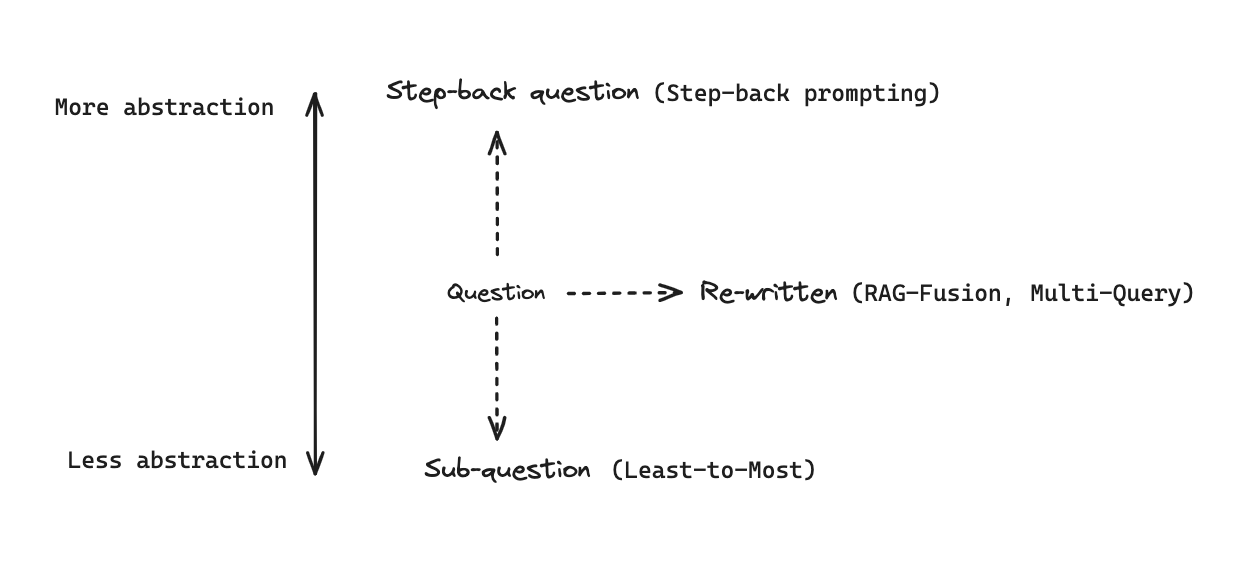

Paper:

- https://arxiv.org/pdf/2310.06117.pdf

In [29]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [30]:
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm(model_name="gpt-4o",temperature=0)

generate_queries_step_back = prompt | llm | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

'What is task decomposition?'

In [31]:
# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | llm
    | StrOutputParser()
)

chain.invoke({"question": question})

'Task decomposition for LLM (Large Language Model) agents involves breaking down complex tasks into smaller, manageable sub-tasks or steps. This process is essential for efficiently handling intricate tasks and ensuring that the agent can systematically approach and solve them. Here are the key aspects of task decomposition for LLM agents:\n\n1. **Chain of Thought (CoT)**: This technique, introduced by Wei et al. in 2022, instructs the model to "think step by step." By decomposing hard tasks into smaller and simpler steps, CoT enhances the model\'s performance on complex tasks. It transforms big tasks into multiple manageable tasks, providing insight into the model\'s thinking process.\n\n2. **Tree of Thoughts (ToT)**: An extension of CoT by Yao et al. in 2023, ToT explores multiple reasoning possibilities at each step. It decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be either breadth-firs

# Approach: HyDE
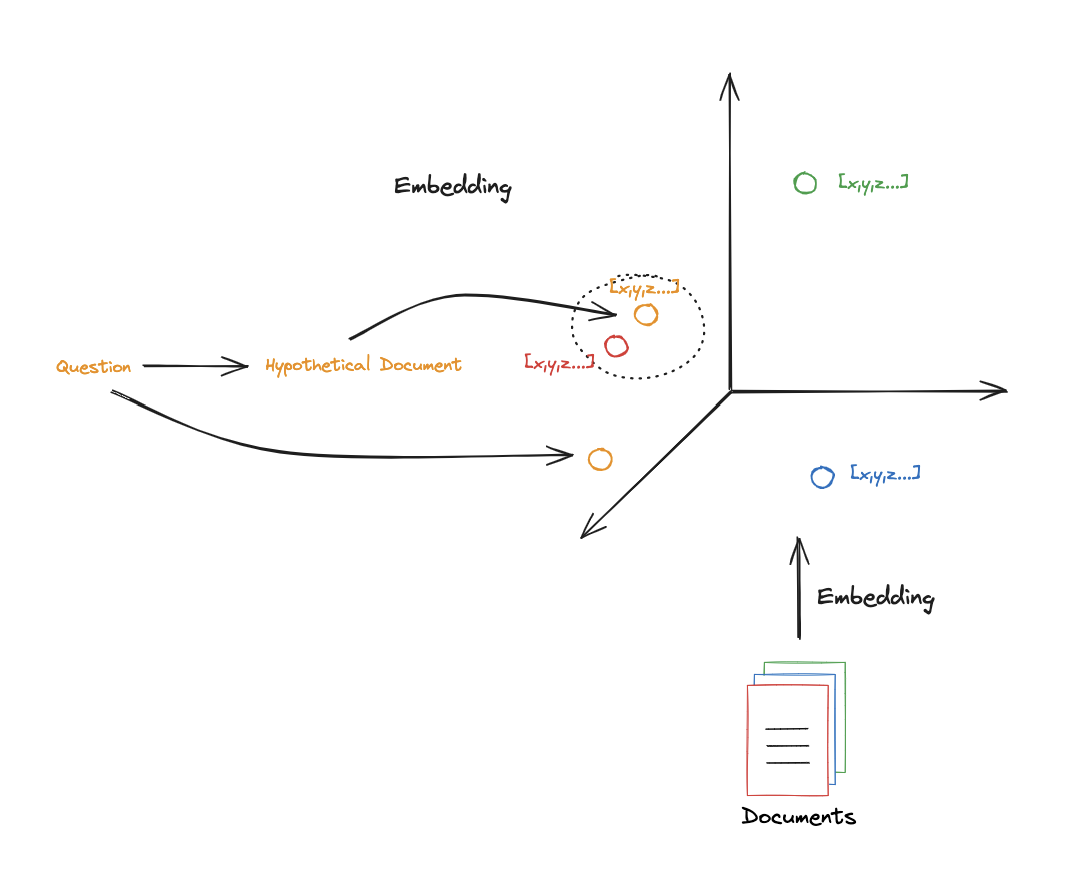

Docs:
- https://github.com/langchain-ai/langchain/blob/master/cookbook/hypothetical_document_embeddings.ipynb

Paper:
- https://arxiv.org/abs/2212.10496

In [36]:
from langchain.prompts import ChatPromptTemplate

# HyDE document generation
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser

from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm(model_name="gpt-4o",temperature=0)

generate_docs_for_retrieval = (prompt_hyde | llm | StrOutputParser() )

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question":question})

'Title: Task Decomposition for Large Language Model (LLM) Agents\n\nAbstract:\nTask decomposition is a critical methodology in the field of artificial intelligence, particularly for Large Language Model (LLM) agents. This process involves breaking down complex tasks into smaller, manageable subtasks, enabling LLMs to perform more efficiently and accurately. This paper explores the principles, benefits, and applications of task decomposition in LLM agents, providing insights into how this approach enhances their problem-solving capabilities.\n\nIntroduction:\nLarge Language Models (LLMs) have demonstrated remarkable proficiency in understanding and generating human language. However, their effectiveness can be significantly enhanced through task decomposition. Task decomposition refers to the systematic breakdown of a complex task into simpler, constituent parts. This approach allows LLM agents to tackle each subtask individually, thereby improving overall performance and accuracy.\n\nP

In [37]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
retrieved_docs = retrieval_chain.invoke({"question":question})
retrieved_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a

In [38]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retrieved_docs,"question":question})

'Task decomposition for LLM (Large Language Model) agents involves breaking down large, complex tasks into smaller, manageable subgoals. This process enables efficient handling of intricate tasks by the agent. There are several methods for task decomposition:\n\n1. **Chain of Thought (CoT)**: This technique instructs the model to "think step by step," decomposing hard tasks into smaller and simpler steps. It transforms big tasks into multiple manageable tasks and provides insight into the model\'s thinking process.\n\n2. **Tree of Thoughts (ToT)**: This method extends CoT by exploring multiple reasoning possibilities at each step. It decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be breadth-first search (BFS) or depth-first search (DFS), with each state evaluated by a classifier or majority vote.\n\n3. **Simple Prompting**: Task decomposition can be done by prompting the LLM with simple inst